## Introduction

Let's predict who won the match given team composition and how long game played out

## Get dataset

In [188]:
import pandas as pd
df = pd.read_csv("games.csv")

Some Setups

In [189]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [190]:
df.head(5)

,game_length,mmr,result,server,team_1,team_2,timestamp
0,25m 38s,NaN,Victory,na,"Riven,Nidalee,Galio,Jhin,Pantheon","Camille,Olaf,Cassiopeia,Ezreal,Alistar",2020-10-13 09:31:42
1,25m 38s,NaN,Defeat,na,"Teemo,Nidalee,Lucian,Caitlyn,Senna","Irelia,Hecarim,Cassiopeia,Jinx,Lulu",2020-10-13 06:00:17
2,25m 38s,NaN,Defeat,na,"Malphite,Olaf,Taliyah,Ezreal,Alistar","Sylas,Lillia,Lucian,Senna,Pantheon",2020-10-13 05:06:45
3,25m 38s,NaN,Defeat,na,"Neeko,Shen,Orianna,Kai'Sa,Nautilus","Riven,Hecarim,Cassiopeia,Samira,Morgana",2020-10-13 04:28:00
4,25m 38s,NaN,Defeat,na,"Fiora,Nunu & Willump,Irelia,Jhin,Karma","Renekton,Elise,Kled,Jinx,Morgana",2020-10-13 04:00:51


In [191]:
temp_df = df[['game_length', 'result', 'team_1', 'team_2']] # Select only interests
blue = temp_df['team_1']
red = temp_df['team_2']
n = len(df)

blue_champs = []
red_champs = []
for i in range(0,n):
    blue_champs += [blue[i].split(',')]
    red_champs += [red[i].split(',')]
    
top = []
jg = []
mid = []
adc = []
sup = []
for i in range(0, n):
    top += [blue_champs[i][0]]
    jg += [blue_champs[i][1]]
    mid += [blue_champs[i][2]]
    adc += [blue_champs[i][3]]
    sup += [blue_champs[i][4]]
    
top_2 = []
jg_2 = []
mid_2 = []
adc_2 = []
sup_2 = []
for i in range(0, n):
    top_2 += [red_champs[i][0]]
    jg_2 += [red_champs[i][1]]
    mid_2 += [red_champs[i][2]]
    adc_2 += [red_champs[i][3]]
    sup_2 += [red_champs[i][4]]

In [192]:
data = temp_df.drop(columns=['team_1','team_2'])
# blue team
data['top1'] = top
data['jg1'] = jg
data['mid1'] = mid
data['adc1'] = adc
data['sup1'] = sup
# red team
data['top2'] = top_2
data['jg2'] = jg_2
data['mid2'] = mid_2
data['adc2'] = adc_2
data['sup2'] = sup_2

In [193]:
data.head(10)


,game_length,result,top1,jg1,mid1,adc1,sup1,top2,jg2,mid2,adc2,sup2
0,25m 38s,Victory,Riven,Nidalee,Galio,Jhin,Pantheon,Camille,Olaf,Cassiopeia,Ezreal,Alistar
1,25m 38s,Defeat,Teemo,Nidalee,Lucian,Caitlyn,Senna,Irelia,Hecarim,Cassiopeia,Jinx,Lulu
2,25m 38s,Defeat,Malphite,Olaf,Taliyah,Ezreal,Alistar,Sylas,Lillia,Lucian,Senna,Pantheon
3,25m 38s,Defeat,Neeko,Shen,Orianna,Kai'Sa,Nautilus,Riven,Hecarim,Cassiopeia,Samira,Morgana
4,25m 38s,Defeat,Fiora,Nunu & Willump,Irelia,Jhin,Karma,Renekton,Elise,Kled,Jinx,Morgana
5,25m 38s,Defeat,Irelia,Karthus,Sylas,Samira,Nautilus,Riven,Kayn,Akali,Miss Fortune,Galio
6,25m 38s,Defeat,Galio,Kindred,Syndra,Ezreal,Blitzcrank,Camille,Fiddlesticks,Twisted Fate,Jhin,Morgana
7,25m 38s,Defeat,Poppy,Ekko,Sylas,Samira,Blitzcrank,Lucian,Lillia,Lulu,Caitlyn,Alistar
8,25m 38s,Defeat,Shen,Lillia,Samira,Lucian,Soraka,Taric,Master Yi,Riven,Ezreal,Lulu
9,25m 38s,Defeat,Ornn,Graves,Sylas,Lucian,Alistar,Irelia,Hecarim,Akali,Senna,Leona


In [194]:
from sklearn.preprocessing import OneHotEncoder
#y = pd.get_dummies(data.top1, prefix='top1')
enc = OneHotEncoder()
only_champs = data.drop(columns=['game_length', 'result'])
only_champs.head(5)
only_champs_onehot = enc.fit_transform(only_champs)


In [195]:
# print(only_champs_onehot)
enc.get_params()

{'categories': 'auto',
 'drop': None,
 'dtype': numpy.float64,
 'handle_unknown': 'error',
 'sparse': True}

In [197]:
# Convert game_length to float and normalize
import re
date_str = data.game_length
m = 2717 #longest games are 45m 17s

for i in range(len(date_str)):
    if type(date_str[i]) == str:
        p = re.compile('\d*')
        min = float(p.findall(date_str[i][:2])[0])
        temp = p.findall(date_str[i][-3:])
        for j in temp:
            if j != '':
                sec = float(j)
                break
        date_str[i] = (60*min+sec)/m
    else: 
        date_str[i] = date_str[i]/m
#     print(date_str[i])
# print(len(date_str))

In [198]:
# Now we have the X we want
#except_champs = data.drop(columns=['result','top1','jg1','mid1','adc1','sup1','top2','jg2','mid2','adc2','sup2'])
sparse_to_df = pd.DataFrame.sparse.from_spmatrix(only_champs_onehot)
print(sparse_to_df.shape)
print(date_str.shape)

X = date_str.to_frame().join(sparse_to_df).dropna()
X = np.asarray(X).astype('float32')

(4028, 754)
(4028,)


In [199]:
y = data['result']
for i in range(len(y)):
    if y[i] == "Victory":
        y[i] = 1
    else:
        y[i] = 0

In [200]:
y = np.asarray(y).astype('float32')

## Datas are one hot encoded and cleaned up. Let's train test split

In [201]:
from sklearn.model_selection import train_test_split
import math

X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
#len(X_train) = 3222
l = math.floor(3222*0.8)
X_valid, X_train = X_train_full[:l], X_train_full[l:]
y_valid, y_train = y_train_full[:l], y_train_full[l:]
print(y_valid.shape)
print(X_valid.shape)


(2577,)
(2577, 755)


## Let's try Neural Network with dropouts

In [202]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(755,)),
    keras.layers.Dense(30, activation="relu", name="layer_1"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(16, activation="relu", name="layer_2"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(16, activation="relu", name="layer_3"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1, activation="sigmoid", name="layer_4")
])

In [203]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 755)               0         
_________________________________________________________________
layer_1 (Dense)              (None, 30)                22680     
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
layer_2 (Dense)              (None, 16)                496       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
layer_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0

In [220]:
model.fit(X_train, y_train, epochs=50, batch_size=1)

In [205]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('accuracy', test_acc)

26/26 [==============================] - 0s 806us/step - loss: 3.8032 - accuracy: 0.6613
accuracy 0.6612903475761414


We got about 0.661 accuracy with just raw neural network with dropouts.

## Let's try random forests

In [206]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=2000, max_leaf_nodes=32, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=32, n_estimators=2000, n_jobs=-1)

In [207]:
y_val_pred = rnd_clf.predict(X_valid)

In [208]:
val_acc = np.sum(y_val_pred == y_valid)/len(y_valid)
print("validation accuracy: "+str(val_acc))


validation accuracy: 0.7710516103996896


In [209]:
y_test_pred = rnd_clf.predict(X_test)
test_acc = np.sum(y_test_pred == y_test)/len(y_test)
print("test accuracy: "+str(test_acc))

test accuracy: 0.7704714640198511


Immediate improvement by almost 10% with random forest classifier!

## Model Explanability

Let's look at what we were mostly interested. What are some best team compositions!

In [210]:
# import eli5
# from eli5.sklearn import PermutationImportance
# perm = PermutationImportance(rnd_clf, random_state=42).fit(X_valid, y_valid)
# eli5.show_weights(perm, feature_names=X_valid.columns.tolist())
# Will take billions years to compute

## Let's try SHAP summary

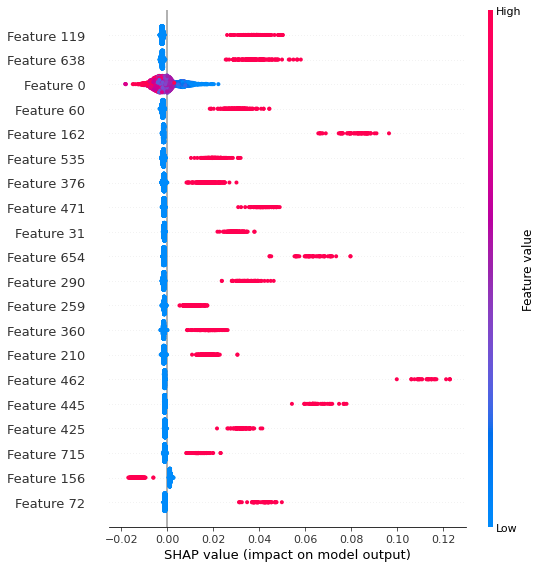

In [211]:
import shap

explainer = shap.TreeExplainer(rnd_clf)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values[1], X_valid)

- We see that feature 0 (game length) tells us that the game favors blue team winning more when game is shorter which is unexpected. Note that it it not significant at all since SHAP value is -0.02 ~ 0.4 at most.
- Generally, since all the values are 0 are 1, we can see clear 1-red and 0-blue (When it's 0 it has no impact on the prediction)
- We can see feature 156(blue Mid Akali) helped RED team win more
- Whereas Feature 462(red Top Tryndamere) helps the BLUE team win significantly more haha
- From this chart, we can clearly see that each champion has very consistent and predictable contribution to their team's chance of winning 

Note that
- 119 Kindred blue jg
- 638 Caitlyn red adc
- 60 Renekton blue top
- 162 Cassiopeia blue mid
- 535 Akali red mid
- 376 Thresh blue support
- 471 Volibear red top
- 31 Jax blue top
- 654 Kalista red adc
- 290 Miss Fortune blue adc
- 259 Ashe blue adc
- 360 Rakan blue support
- 210 Orianna blue mid
- 462 Tryndamere red top
- 445 Riven red top
- 425 Lucian red top
- 715 Janna red support
- 156 Akali blue mid
- 72 Sylas blue top

Therefore our best teamp comp impacting positively on winning is ...
- (Top)Renekton/Jax/Sylas (Jg)Kindred (Mid) Cassiopeia/Orianna (Adc)MF/Ashe (Sup)Thresh/Rakan

Meanwhile worst team comp impacting negatively on winning is ...
- (Top)Volibear/Trynd/Riven/Lucian (Mid)Akali (Adc)Caitlyn/Kalista (Sup)Janna

We can also note that Jg role seem to not matter much.. : )

In [212]:
# function to find champ given feature number i
def find_champ(i):
    temp_list = [99,54,101,73,57,96,52,102,68,52]
    for num in range(len(temp_list)):
        if (i-temp_list[num] <= 0):
            return enc.categories_[num][i-1]
        else:
            i = i-temp_list[num]

In [114]:
# Some things helpful converting sparse matrix into something we can comprehend
# list_champ = [119, 638,60,162,535,376,471,31,654,290,259,360,210,462,445,425,715,156,72]
# for champ in list_champ:
#     lane = ''
#     if champ <= 99 or 385<=champ<=480:
#         lane = "top"
#     elif 100 <= champ <=153 or 481<=champ<=532:
#         lane = "jg"
#     elif 154 <= champ <=255 or 533<=champ<=634:
#         lane= "mid"
#     elif 256 <= champ <=327 or 635<=champ<=702:
#         lane= "adc"
#     else:
#         lane = "support"
#     team = "blue" if champ <= 384 else "red"
#     print(champ, find_champ(champ), team, lane)
#print(len(enc.categories_[0]))    99
#print(len(enc.categories_[1]))    54   //153
#print(len(enc.categories_[2]))    101  //254
#print(len(enc.categories_[3]))    73   //327
#print(len(enc.categories_[4]))    57  // UP TO 384 is blue team
#print(len(enc.categories_[5]))    96  //480
#print(len(enc.categories_[6]))    52  //532
#print(len(enc.categories_[7]))    102  //634
#print(len(enc.categories_[8]))    68   //702
#print(len(enc.categories_[9]))    52   //754

## What if we didn't have game length, just champion compositions only?

In [214]:
X_1 = sparse_to_df

In [215]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_1,y,test_size=0.2, random_state=42)
#len(X_train) = 3222
l = math.floor(3222*0.8)
X_valid, X_train = X_train_full[:l], X_train_full[l:]
y_valid, y_train = y_train_full[:l], y_train_full[l:]
print(y_valid.shape)
print(X_valid.shape)

(2577,)
(2577, 754)


In [217]:
rnd_clf = RandomForestClassifier(n_estimators=2000, max_leaf_nodes=32, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=32, n_estimators=2000, n_jobs=-1)

In [218]:
y_val_pred = rnd_clf.predict(X_valid)
val_acc = np.sum(y_val_pred == y_valid)/len(y_valid)
print("validation accuracy: "+str(val_acc))

validation accuracy: 0.7691113698098564


In [219]:
y_test_pred = rnd_clf.predict(X_test)
test_acc = np.sum(y_test_pred == y_test)/len(y_test)
print("test accuracy: "+str(test_acc))

test accuracy: 0.7692307692307693


Surprisingly, accuracy only drops less than 0.01. We can conclude that planning out a team comp based on champion's strength on early vs late game does not help win more. This can be explained by an example. Let's say I picked kayle which is the best late game champion. We may win games with longer duration more but will lose more short games due to her weakness early. So the overall win rate balances out.

## Conclusion

- best: (Top)Renekton/Jax/Sylas (Jg)Kindred (Mid) Cassiopeia/Orianna (Adc)MF/Ashe (Sup)Thresh/Rakan 
- worst: (Top)Volibear/Trynd/Riven/Lucian (Mid)Akali (Adc)Caitlyn/Kalista (Sup)Janna 

We know that in the world of solo queue, picking the above champions will not gurantee a win. Sometimes people are autofilled, meaning they aren't playing on their best role. People may disconnect, resulting in games favoring the opposite team. There are too many unknown factors like this, making it impossible to predict 100% of the game outcomes correctly. 

As a former high elo NA player myself, I can say that generally, the 'best team' above have champions that doesn't get countered too often and is a good pick into anything. (This may not be the case for top because I've never really cared about top lanes as a support player :). But for 'worst team' champions, they are often easily countered. (Especially bottom lane) 

The biggest surprise was blue team wins more early and red team wins more late (Very slightly but certainly) for some reason. 
Also jg mattering the least was a surprise as well. 